In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'


In [2]:
import json
from PIL import Image
from collections import Counter

import numpy as np
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from skimage import draw

import pytorch_lightning as pl
import torch
import torchvision
from torchvision import transforms as T
import segmentation_models_pytorch as smp


from torch.utils.data import Dataset, DataLoader, Subset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from scipy.ndimage import label

In [3]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    GaussNoise, MotionBlur, MedianBlur, PiecewiseAffine,
    Sharpen, Emboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose, Normalize, Resize, RandomBrightnessContrast
)
from albumentations.pytorch import ToTensorV2

def get_transforms(mode='val'):
    
    if mode == 'train':
        return Compose([
            Resize(512, 512),
            GaussNoise(p=0.3),
            OneOf([
                MotionBlur(p=0.2),
                MedianBlur(blur_limit=3, p=0.1),
                Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            OneOf([
                OpticalDistortion(p=0.3),
                GridDistortion(p=0.1),
                PiecewiseAffine(p=0.3),
            ], p=0.2),
            OneOf([
                Sharpen(),
                Emboss(),
                RandomBrightnessContrast(),
            ], p=0.3),
            HueSaturationValue(p=0.3),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

    return Compose([
        Resize(512, 512),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

In [4]:
meta = pd.read_csv('../data/tile_meta.csv')

In [5]:
meta = meta[meta.dataset != 3]

In [6]:
meta.head(1)

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420


In [7]:
meta.shape

(1633, 5)

In [8]:
meta.dataset.value_counts()

2    1211
1     422
Name: dataset, dtype: int64

In [9]:
meta[meta.dataset==1].source_wsi.value_counts()

1    270
2    152
Name: source_wsi, dtype: int64

In [10]:
meta[meta.dataset==2].source_wsi.value_counts()

3    410
2    293
4    271
1    237
Name: source_wsi, dtype: int64

In [11]:
meta = meta[meta.source_wsi.apply(lambda i: i in [1, 2])]

In [12]:
meta.source_wsi.value_counts()

1    507
2    445
Name: source_wsi, dtype: int64

In [13]:
meta = pd.concat([meta[meta.dataset == 2].sample(422), meta[meta.dataset == 1]])

In [14]:
meta = meta.sample(frac=1)

In [15]:
meta['label'] = (meta.dataset == 1).astype(int)

In [16]:
meta = meta[['id', 'label']]

In [17]:
BASE_FILENAME = '../data/'
BATCH_SIZE = 16
NUM_WORKERS = 1
# BASE_FILENAME = '/kaggle/input/hubmap-hacking-the-human-vasculature'

In [18]:
class BasicHubmapDataset(Dataset):

    def __init__(self, image_dir, df, transforms):
        self.df = df
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = row.label
        image_path = os.path.join(self.image_dir, f"{row.id}.tif")
        image = np.array(Image.open(image_path))
        mask = np.zeros((512, 512), dtype=np.float32)
        for coords in row.annotation:
            for cord in coords:
                rr, cc = np.array([i[1] for i in cord]), np.asarray([i[0] for i in cord])
                rr, cc = draw.polygon(rr, cc)
                mask[rr, cc] = 1

        sample = self.transforms(image=image, mask=mask)
        sample['label'] = row.label
        return sample

In [21]:
train_transforms = get_transforms(mode='train')
val_transforms = get_transforms(mode='val')

In [22]:
rows = []
with open(f'{BASE_FILENAME}/polygons.jsonl', 'r') as json_file:
    for line in json_file:
        data = json.loads(line)
        row = dict({'id': data['id']})
        coords = []
        for ann in data['annotations']:
            if ann['type'] == 'blood_vessel':
                coords.append(ann['coordinates'])
        row['annotation'] = coords
        rows.append(row)
df = pd.DataFrame(rows)

In [23]:
df = df.merge(meta, on='id')

In [24]:
df.head()

,id,annotation,label
0,0006ff2aa7cd,"[[[[283, 109], [282, 109], [281, 109], [280, 1...",0
1,00168d1b7522,"[[[[501, 257], [500, 257], [499, 257], [498, 2...",0
2,0033bbc76b6b,"[[[[169, 228], [168, 228], [167, 228], [166, 2...",1
3,00654cc08aac,"[[[[1, 136], [0, 136], [0, 135], [0, 134], [0,...",0
4,00656c6f2690,"[[[[511, 426], [511, 426], [510, 426], [510, 4...",1


In [25]:
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

In [26]:
train_dataset = BasicHubmapDataset(f'{BASE_FILENAME}/train', train_df, train_transforms)
val_dataset = BasicHubmapDataset(f'{BASE_FILENAME}/train', val_df, val_transforms)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=5)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=5)

In [35]:
import cv2
def plot_sample(image, mask):

    image = image.permute(1, 2, 0).numpy()
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225]) 
    image = (image * std) + mean


    masked = image.copy()
#     masked[mask == 1] = [1, 0, 0]  # Red color for mask
    mask = mask.numpy().astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_mask = cv2.drawContours(masked, contours, -1, (1), thickness=3)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[1].imshow(contours_mask)
    ax[1].set_title('Image with mask')

    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

    plt.show()


In [324]:
for batch in train_loader:
    break

In [52]:
import cv2
import numpy as np
from skimage import color
from typing import Optional, Dict
import yaml

# ToDo: add documents


class Dict2Class(object):
    # ToDo: Wrap into RandStainNA
    def __init__(self, my_dict: Dict):
        self.my_dict = my_dict
        for key in my_dict:
            setattr(self, key, my_dict[key])


def get_yaml_data(yaml_file):
    # ToDo: Wrap into RandStainNA
    file = open(yaml_file, "r", encoding="utf-8")
    file_data = file.read()
    file.close()
    # str->dict
    data = yaml.load(file_data, Loader=yaml.FullLoader)

    return data


class RandStainNA(object):
    # ToDo: support downloading yaml file from online if the path is not provided.
    def __init__(
        self,
        yaml_file: str,
        std_hyper: Optional[float] = 0,
        distribution: Optional[str] = "normal",
        probability: Optional[float] = 1.0,
        is_train: Optional[bool] = True,
    ):

        # true:training setting/false: demo setting

        assert distribution in [
            "normal",
            "laplace",
            "uniform",
        ], "Unsupported distribution style {}.".format(distribution)

        self.yaml_file = yaml_file
        cfg = get_yaml_data(self.yaml_file)
        c_s = cfg["color_space"]

        self._channel_avgs = {
            "avg": [
                cfg[c_s[0]]["avg"]["mean"],
                cfg[c_s[1]]["avg"]["mean"],
                cfg[c_s[2]]["avg"]["mean"],
            ],
            "std": [
                cfg[c_s[0]]["avg"]["std"],
                cfg[c_s[1]]["avg"]["std"],
                cfg[c_s[2]]["avg"]["std"],
            ],
        }
        self._channel_stds = {
            "avg": [
                cfg[c_s[0]]["std"]["mean"],
                cfg[c_s[1]]["std"]["mean"],
                cfg[c_s[2]]["std"]["mean"],
            ],
            "std": [
                cfg[c_s[0]]["std"]["std"],
                cfg[c_s[1]]["std"]["std"],
                cfg[c_s[2]]["std"]["std"],
            ],
        }

        self.channel_avgs = Dict2Class(self._channel_avgs)
        self.channel_stds = Dict2Class(self._channel_stds)

        self.color_space = cfg["color_space"]
        self.p = probability
        self.std_adjust = std_hyper
        self.color_space = c_s
        self.distribution = distribution
        self.is_train = is_train

    def _getavgstd(self, image: np.ndarray, isReturnNumpy: Optional[bool] = True):

        avgs = []
        stds = []

        num_of_channel = image.shape[2]
        for idx in range(num_of_channel):
            avgs.append(np.mean(image[:, :, idx]))
            stds.append(np.std(image[:, :, idx]))

        if isReturnNumpy:
            return (np.array(avgs), np.array(stds))
        else:
            return (avgs, stds)

    def _normalize(
        self,
        img: np.ndarray,
        img_avgs: np.ndarray,
        img_stds: np.ndarray,
        tar_avgs: np.ndarray,
        tar_stds: np.ndarray,
    ) -> np.ndarray:

        img_stds = np.clip(img_stds, 0.0001, 255)
        img = (img - img_avgs) * (tar_stds / img_stds) + tar_avgs

        if self.color_space in ["LAB", "HSV"]:
            img = np.clip(img, 0, 255).astype(np.uint8)

        return img

    def augment(self, img):
        # img:is_train:false——>np.array()(cv2.imread()) #BGR
        # img:is_train:True——>PIL.Image #RGB

        if self.is_train == False:
            image = img
        else:
            image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

        num_of_channel = image.shape[2]

        # color space transfer
        if self.color_space == "LAB":
            image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        elif self.color_space == "HSV":
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif self.color_space == "HED":
            image = color.rgb2hed(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        std_adjust = self.std_adjust

        # virtual template generation
        tar_avgs = []
        tar_stds = []
        if self.distribution == "uniform":

            # three-sigma rule for uniform distribution
            for idx in range(num_of_channel):

                tar_avg = np.random.uniform(
                    low=self.channel_avgs.avg[idx] - 3 * self.channel_avgs.std[idx],
                    high=self.channel_avgs.avg[idx] + 3 * self.channel_avgs.std[idx],
                )
                tar_std = np.random.uniform(
                    low=self.channel_stds.avg[idx] - 3 * self.channel_stds.std[idx],
                    high=self.channel_stds.avg[idx] + 3 * self.channel_stds.std[idx],
                )

                tar_avgs.append(tar_avg)
                tar_stds.append(tar_std)
        else:
            if self.distribution == "normal":
                np_distribution = np.random.normal
            elif self.distribution == "laplace":
                np_distribution = np.random.laplace

            for idx in range(num_of_channel):
                tar_avg = np_distribution(
                    loc=self.channel_avgs.avg[idx],
                    scale=self.channel_avgs.std[idx] * (1 + std_adjust),
                )

                tar_std = np_distribution(
                    loc=self.channel_stds.avg[idx],
                    scale=self.channel_stds.std[idx] * (1 + std_adjust),
                )
                tar_avgs.append(tar_avg)
                tar_stds.append(tar_std)

        tar_avgs = np.array(tar_avgs)
        tar_stds = np.array(tar_stds)

        img_avgs, img_stds = self._getavgstd(image)

        image = self._normalize(
            img=image,
            img_avgs=img_avgs,
            img_stds=img_stds,
            tar_avgs=tar_avgs,
            tar_stds=tar_stds,
        )

        if self.color_space == "LAB":
            image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)
        elif self.color_space == "HSV":
            image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        elif self.color_space == "HED":
            nimg = color.hed2rgb(image)
            imin = nimg.min()
            imax = nimg.max()
            rsimg = (255 * (nimg - imin) / (imax - imin)).astype(
                "uint8"
            )  # rescale to [0,255]

            image = cv2.cvtColor(rsimg, cv2.COLOR_RGB2BGR)

        return image

    def __call__(self, img):
        if np.random.rand(1) < self.p:
            return self.augment(img)
        else:
            return img

    def __repr__(self):
        format_string = self.__class__.__name__ + "("
        format_string += f"methods=Reinhard"
        format_string += f", colorspace={self.color_space}"
        format_string += f", mean={self._channel_avgs}"
        format_string += f", std={self._channel_stds}"
        format_string += f", std_adjust={self.std_adjust}"
        format_string += f", distribution={self.distribution}"
        format_string += f", p={self.p})"
        return format_string

In [47]:
i = np.random.choice(range(len(train_dataset)))

In [48]:
image, mask, target = train_dataset[i].values()

1


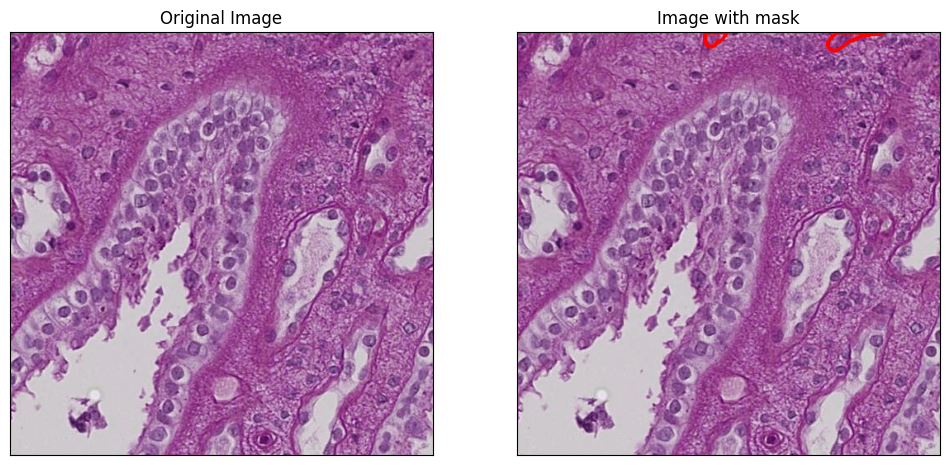

In [49]:
print(target)
plot_sample(image, mask)

0


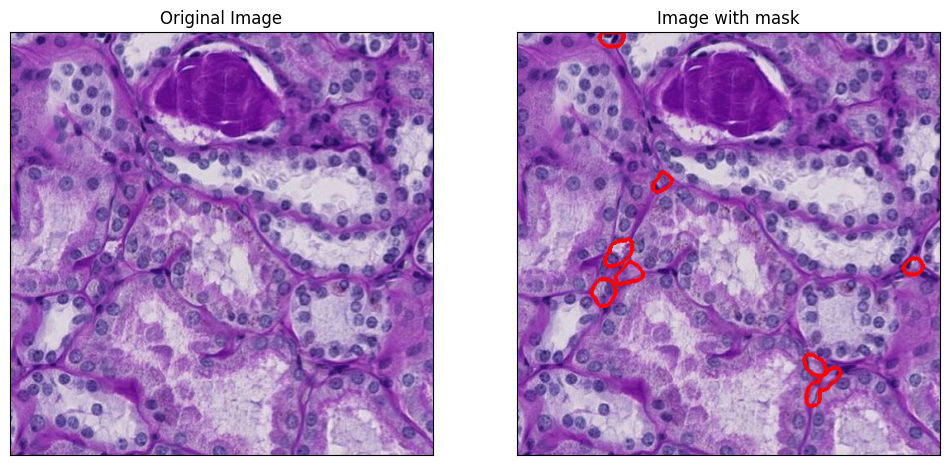

In [51]:
i = np.random.choice(range(len(train_dataset)))
image, mask, target = train_dataset[i].values()
print(target)
plot_sample(image, mask)

In [53]:
class LitModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=3, classes=1, **kwargs
        )

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, batch):
        # normalize image here
        image = batch["image"]
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        mask = batch["mask"].unsqueeze(1)
        logits_mask = self.forward(batch)
        loss = self.loss_fn(logits_mask, mask)


        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        self.log(f"loss/{stage}", loss)
        self.log(f"iou/{stage}", per_image_iou)

        
        return {
            "loss": loss,
            "iou": per_image_iou,
        }
    
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, 'val')
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=1e-3)

In [297]:
model = LitModel()

In [298]:
trainer = pl.Trainer(
    accelerator='gpu',
    devices=[0],
    max_epochs=100,
    logger=pl.loggers.TensorBoardLogger("../tb_logs", name='effnetb2_only_mask_wsi_1&2'),
    log_every_n_steps=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [299]:
trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=val_loader,
)

Missing logger folder: ../tb_logs/effnetb2_only_mask_wsi_1&2
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | EfficientNet      | 7.7 M 
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
4 | train_auc | AUROC             | 0     
5 | val_auc   | AUROC             | 0     
------------------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
30.807    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]